<h1><center>Curso: Modelamiento e interpretación de anomalías gravimétricas usando python</center></h1>

<center><img src="LOGO_SIGAC.svg"></center>

In [36]:
#importar librerias
import simpeg
import gempy as gp
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity
# from skimage.transform import resize
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
write_output = False
import pickle
# import pyvista as pv

In [37]:
datos = pd.read_csv("Dataset_1.csv", sep=';')
columnas = datos.columns.tolist()[:3]
print(f"\nUsando estas columnas como X, Y, Z: {columnas}")


Usando estas columnas como X, Y, Z: ['X', 'Y', 'Z']


In [38]:
#DEFINIR TOPOGRAFÍA
# Usar esas columnas para los datos de topografía
x_topo = datos[columnas[0]]
y_topo = datos[columnas[1]]
z_topo = datos[columnas[2]]

# Convertir a arrays numpy
import numpy as np
x_topo = x_topo.to_numpy()
y_topo = y_topo.to_numpy()
z_topo = z_topo.to_numpy()

# Usando mkvc (asegúrate de importarlo)
from discretize.utils import mkvc
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)

# Combinar en un array
topo_xyz = np.c_[x_topo, y_topo, z_topo]

# Ver el resultado
print(topo_xyz)

[[5.28678917e+02 2.00000000e+03 7.00000000e+02]
 [5.28678917e+02 1.75714481e+03 7.00000000e+02]
 [5.28678917e+02 1.45551921e+03 7.00000000e+02]
 [5.24710159e+02 1.15786236e+03 7.00000000e+02]
 [5.32647675e+02 8.80049305e+02 7.00000000e+02]
 [5.32647675e+02 5.62548670e+02 7.00000000e+02]
 [5.32647675e+02 2.33141761e+02 7.00000000e+02]
 [5.32647675e+02 1.86265000e-09 7.00000000e+02]
 [9.57304774e+02 2.00000000e+03 7.00000000e+02]
 [9.53336016e+02 1.76508233e+03 7.00000000e+02]
 [9.65242290e+02 1.50314430e+03 7.00000000e+02]
 [9.69211048e+02 1.17770615e+03 7.00000000e+02]
 [9.85086080e+02 8.87986821e+02 7.00000000e+02]
 [9.77148564e+02 6.18111281e+02 7.00000000e+02]
 [9.89054837e+02 2.68860582e+02 7.00000000e+02]
 [9.89054837e+02 1.86265000e-09 7.00000000e+02]
 [9.31323000e-10 7.21298987e+02 7.00000000e+02]
 [3.22303504e+02 7.33205261e+02 7.00000000e+02]
 [7.23148056e+02 7.21298987e+02 7.00000000e+02]
 [1.09621130e+03 7.21298987e+02 7.00000000e+02]
 [1.43355573e+03 7.17330229e+02 7.000000

In [39]:
columnas = datos.columns.tolist()[:3]
print(f"\nUsando estas columnas como X, Y, Z: {columnas}")

# Usar esas columnas para los datos de topografía
x_topo = datos[columnas[0]]
y_topo = datos[columnas[1]]
z_topo = datos[columnas[2]]


Usando estas columnas como X, Y, Z: ['X', 'Y', 'Z']


In [40]:
#DEFINIR EL LEVANTAMIENTO, ESTUDIO, SONDEO... (SURVEY)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo) #Interpolación de los puntos xyz
z = fun_interp(np.c_[x_topo, y_topo]) + 5.0
receiver_locations = np.c_[x_topo, y_topo, z]

components = ["gz"] # Se definen los componentes del campo que queremos simular con cadenas dentro de una lista
                    # Aqui solo se simula el componente vertical de la anomalía gravitatoria
receiver_list = gravity.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]   #Se usan las ubicaciones de observación y los componentes para definir los receptores
                                  #Para simular dichos datos, los receptores deben definirse como una lista
source_field = gravity.sources.SourceField(receiver_list=receiver_list) #Definir el campo de origen

survey = gravity.survey.Survey(source_field)   #Definir el sondeo (SURVEY)

# receiver_locations
z

array([705., 705., 705., 705., 705., 705., 705., 705., 705., 705., 705.,
       705., 705., 705., 705., 705., 705., 705., 705., 705., 705., 705.,
       705., 705., 705., 705., 705., 705., 705., 705.])

In [41]:
#importar modelo de gempy
geo_model = pickle.load(open("Modelo_1.pickle", "rb"))

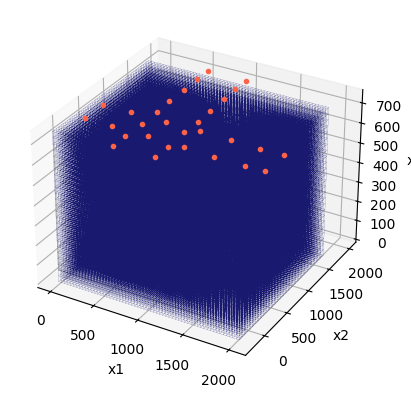

In [42]:
dx = 35
ncx = 58
dy = 35
ncy = 55
dz = 30
ncz = 25


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
grid = TensorMesh([hx, hy, hz], x0=[0,-250,0])
# cell_centers = meshes.cell_centers
# xy_ravel=cell_centers
                           
grid.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')

In [43]:
#visualización del modelo de litologías

sol_block = gp.compute_model_at(geo_model, grid.gridCC)


Active grids: GridTypes.NONE|SECTIONS|CUSTOM|DENSE
Setting Backend To: AvailableBackends.numpy
Chunking done: 9 chunks
Chunking done: 9 chunks
Chunking done: 74 chunks


In [44]:
background_density = 2.9

densities = {
    0: background_density,  # Densidad del complejo metamórfico (g/cm³) #2.9
    1: 2.2,  # Densidad de Complejo_Dacitico                            #2.2
    2: 2.4,  # Densidad de Cuerpo_Intrusivo                             #2.4
    3: 2.5,  # Densidad de Flujo_Piroclastico                           #2.5
    4: 2.6,  # Densidad de Sucesion_Piroclastica                        #2.6
    5: 2.7  # Densidad de Sucesion_Volcanica                            #2.7
}

# Encontrar los índices para las celdas de malla activas (por ejemplo, celdas debajo de la superficie)
ind_active = active_from_xyz(grid, topo_xyz)

# Definir el mapeo del modelo a las celdas activas
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Definir el modelo. Los modelos en SimPEG son arrays vectoriales.
model = np.zeros(nC)

# Mapear los valores de contraste de densidad del modelo GemPy al modelo SimPEG
for i, density in densities.items():
    ind_lith = sol_block[ind_active] == i
    model[ind_lith] = density - background_density 

In [45]:
# Configurar el survey (asumiendo que ya lo tienes definido como en tu código anterior)
# survey = gravity.survey.Survey(source_field)

# Crear el problema de gravedad
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=grid,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
    engine="geoana",
)


# Realizar la simulación directa
d_pred = simulation.dpred(model)

c:\Users\gabri\anaconda3\envs\Curso_Gravimetria\lib\site-packages\simpeg\potential_fields\gravity\simulation.py:188: FutureWarning: 'ind_active' has been deprecated and will be removed in  SimPEG v0.24.0, please use 'active_cells' instead.
  super().__init__(mesh, engine=engine, numba_parallel=numba_parallel, **kwargs)


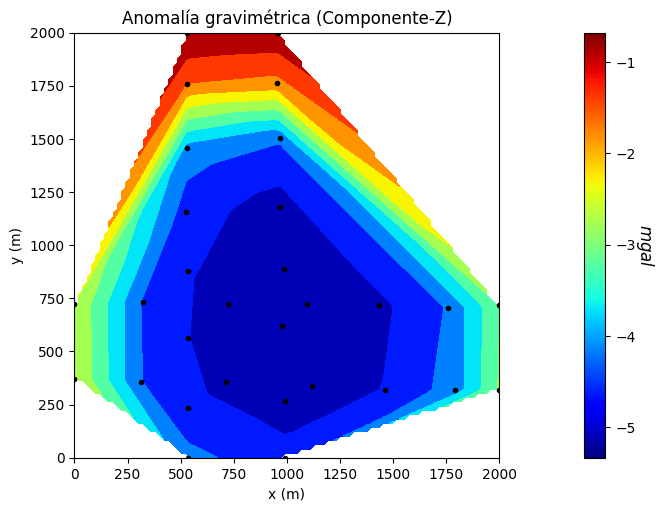

In [46]:
# Plot
from SimPEG.utils import plot2Ddata, model_builder
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, -d_pred, ax=ax1, contourOpts={"cmap": "jet"})
ax1.set_title("Anomalía gravimétrica (Componente-Z)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")


plt.plot(x_topo, y_topo, '.', color='black', )

ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(d_pred)), vmax=np.max(-d_pred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap="jet", #format="%.0e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [48]:
# # Visualizar el modelo de contraste de densidad
# fig = plt.figure(figsize=(10, 5))
# plotting_map = maps.InjectActiveCells(grid, ind_active, np.nan)

# ax1 = fig.add_axes([0.1, 0.12, 0.83, 0.78])
# grid.plot_slice(
#     plotting_map * model,
#     normal="Y",
#     ax=ax1,
#     ind=int(grid.shape_cells[1] / 3),
#     grid=False,
#     clim=(np.min(model), np.max(model)),
#     pcolor_opts={"cmap": "jet"},
# )
# ax1.set_title("Modelo de contraste de densidades en Y = 987541")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)")

# ax2 = fig.add_axes([0.95, 0.12, 0.03, 0.78])
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
# )
# cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

# # plt.savefig('contraste_de_densidad_Y.png', dpi=300)

# plt.show()